# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Niklas Gunnarsson, Carl Andersson, Daniel Gedon

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Yikun Hou, Yiran Wang</font>

- **Team ID:** <font color='red'>Y</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/42324/assignments/254507

**Due Date:** August 25, 2023.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [ ]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 26.0 MB/s eta 0

In [ ]:
# Import
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [ ]:
# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

--2023-07-11 09:44:00--  https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9zkqa5y5jqakdil/codesubset.tar.gz [following]
--2023-07-11 09:44:00--  https://www.dropbox.com/s/raw/9zkqa5y5jqakdil/codesubset.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc31c3f2d73e46577b6afd7ec16c.dl.dropboxusercontent.com/cd/0/inline/B_rxmXWgD69S4tqvC7eRNjfcAloewWYb3txgtj5h8iIPvuXKu-dr9pDXm5LUAYE_V9Atb5RBcY_RlOE4jLGgKPrChtRxtg7SBFybDpzIxTi8ziPOCuzVlkWpGd5syhYvdLDP4zL2fHS4C75TyB36Ov_DDuy5oviou1tXpEqT2WfhHA/file# [following]
--2023-07-11 09:44:01--  https://uc31c3f2d73e46577b6afd7ec16c.dl.dropboxusercontent.com/cd/0/inline/B_rxmXWgD69S4tqvC7eRNjfcAloewWYb3txgtj5h8iIPvuXKu-dr9pDXm5LU

In [ ]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [ ]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/antonior92/ecg-preprocessing.git

Cloning into 'ecg-preprocessing'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 19), reused 32 (delta 12), pack-reused 0
Unpacking objects: 100% (43/43), 386.26 KiB | 4.15 MiB/s, done.


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

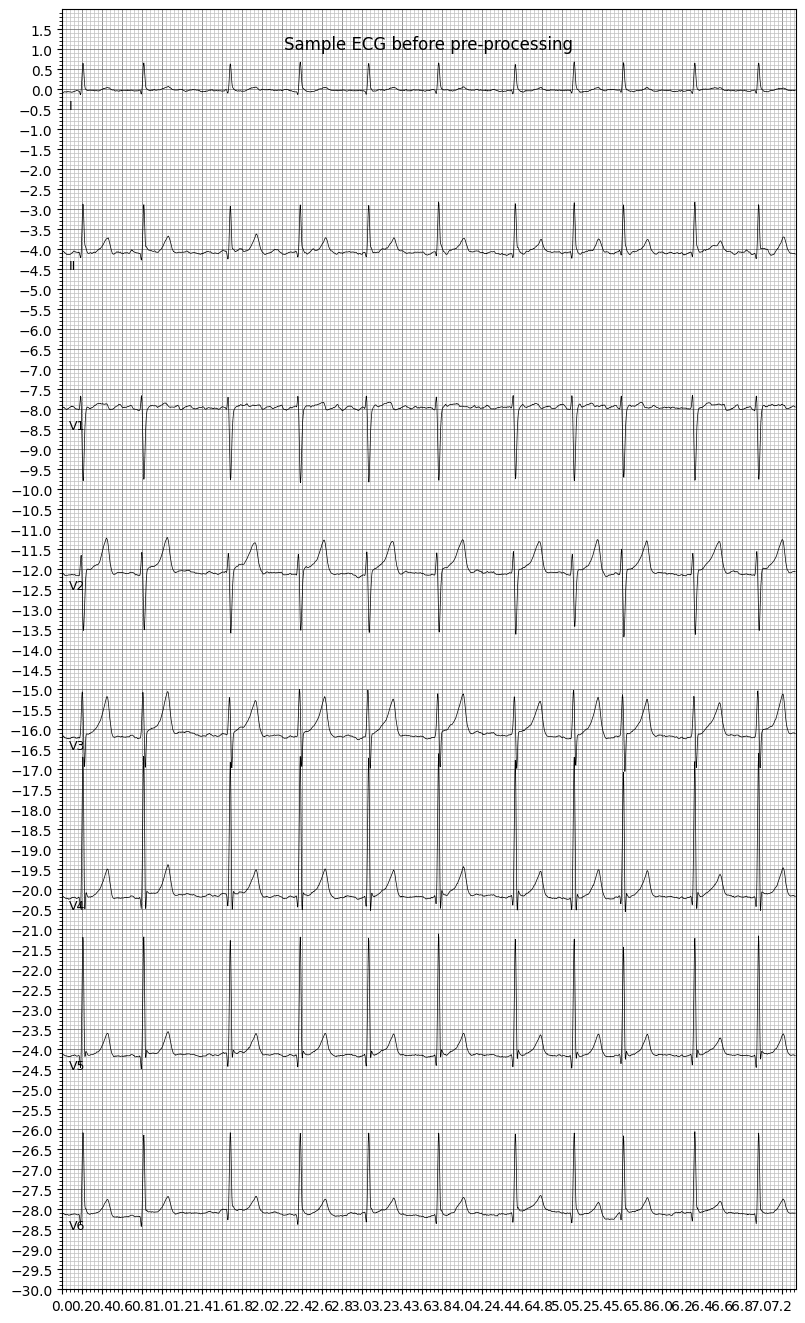

In [ ]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


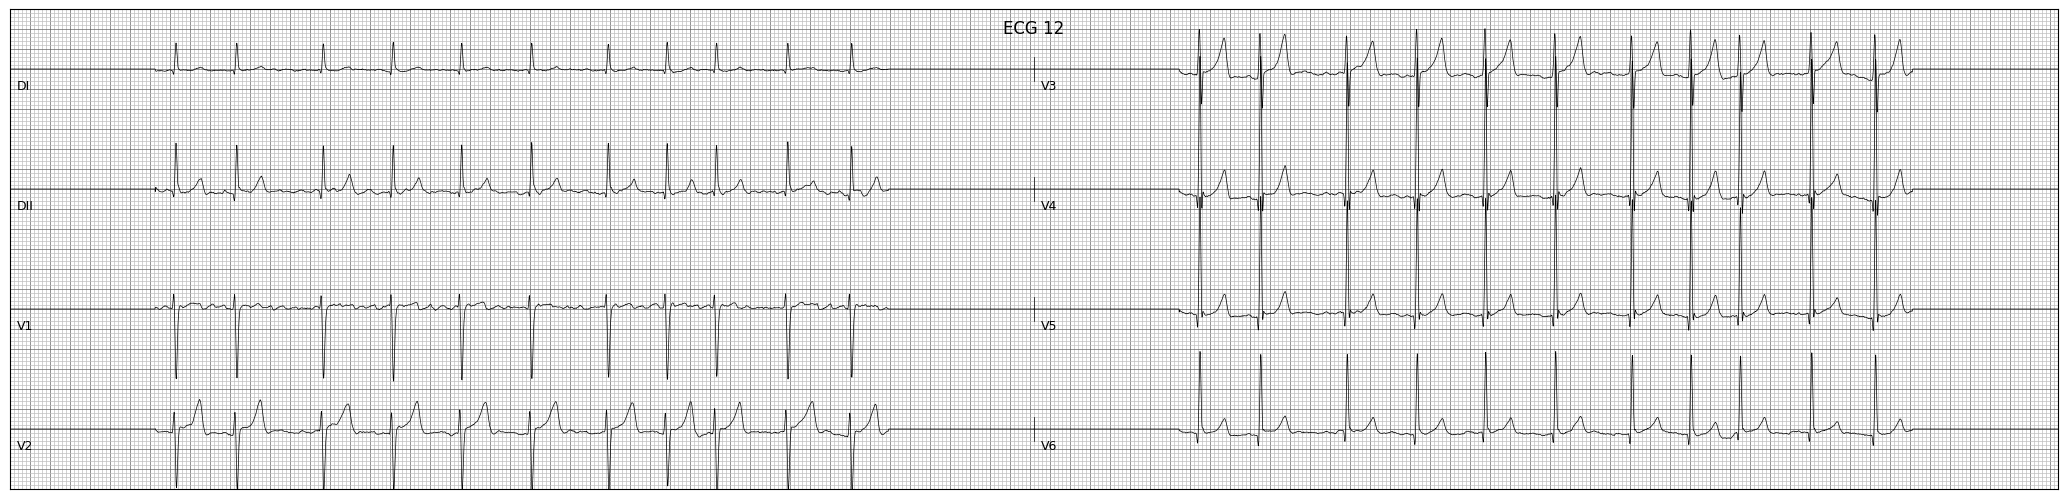

<Figure size 640x480 with 0 Axes>

In [ ]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [ ]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(input_file='codesubset/train/RECORDS.txt', out_file='codesubset/train.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 10000/10000 [01:10<00:00, 142.26it/s]
Namespace(input_file='codesubset/test/RECORDS.txt', out_file='codesubset/test.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 6000/6000 [00:41<00:00, 144.51it/s]


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


<Figure size 640x480 with 0 Axes>

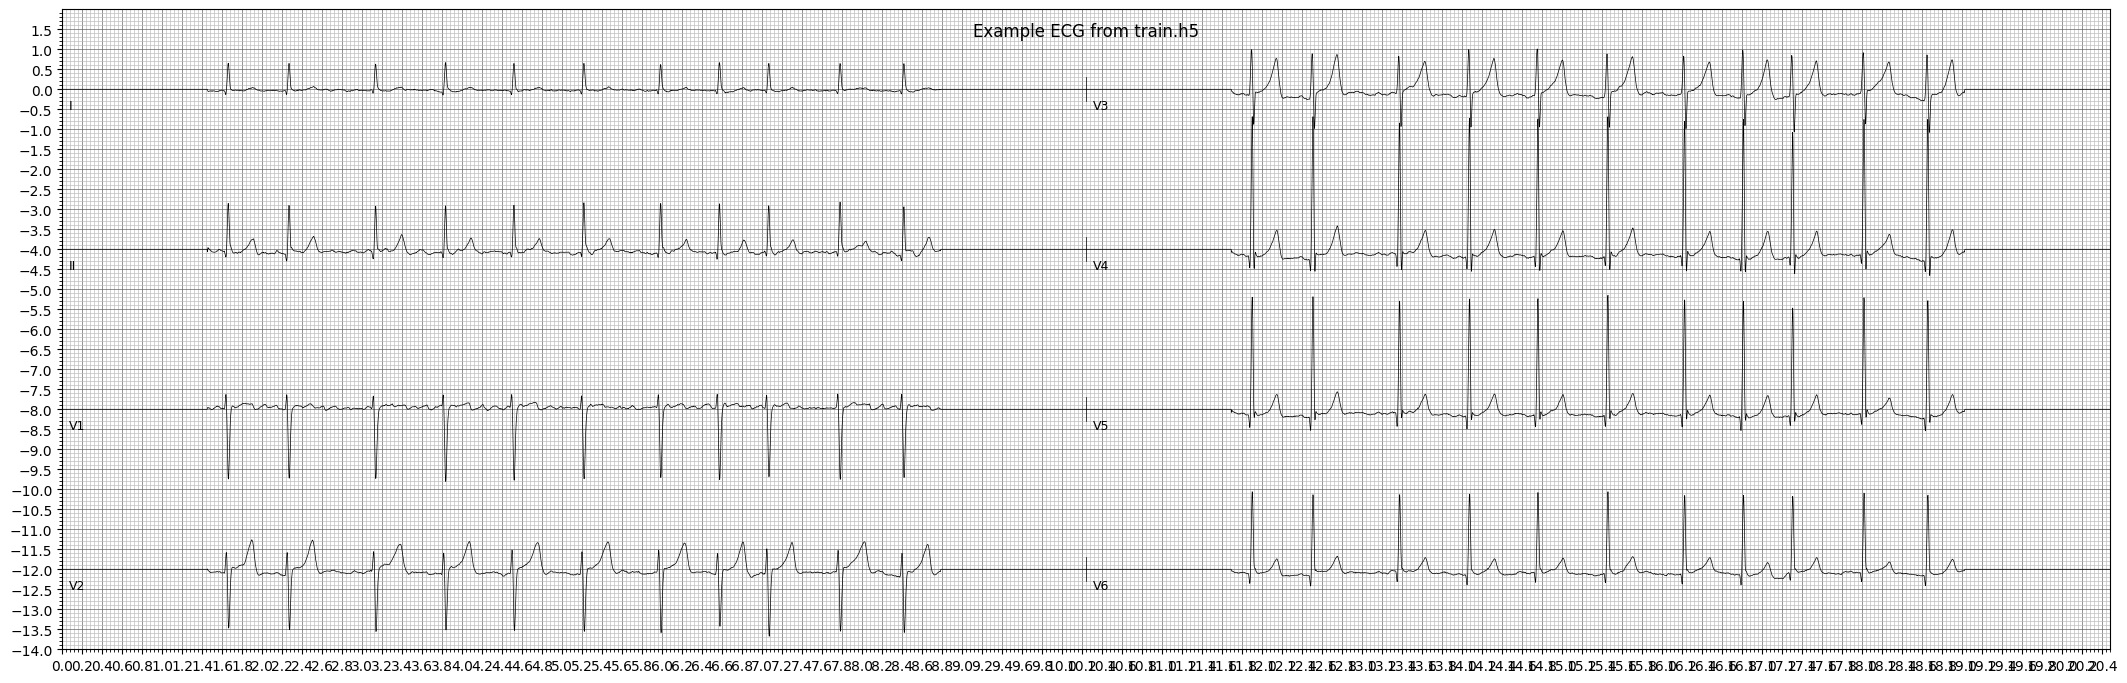

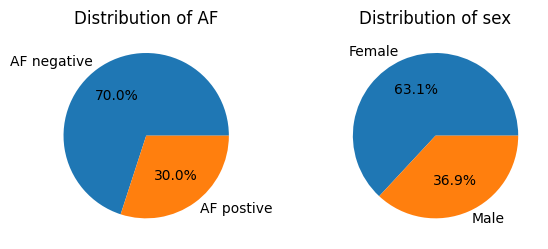

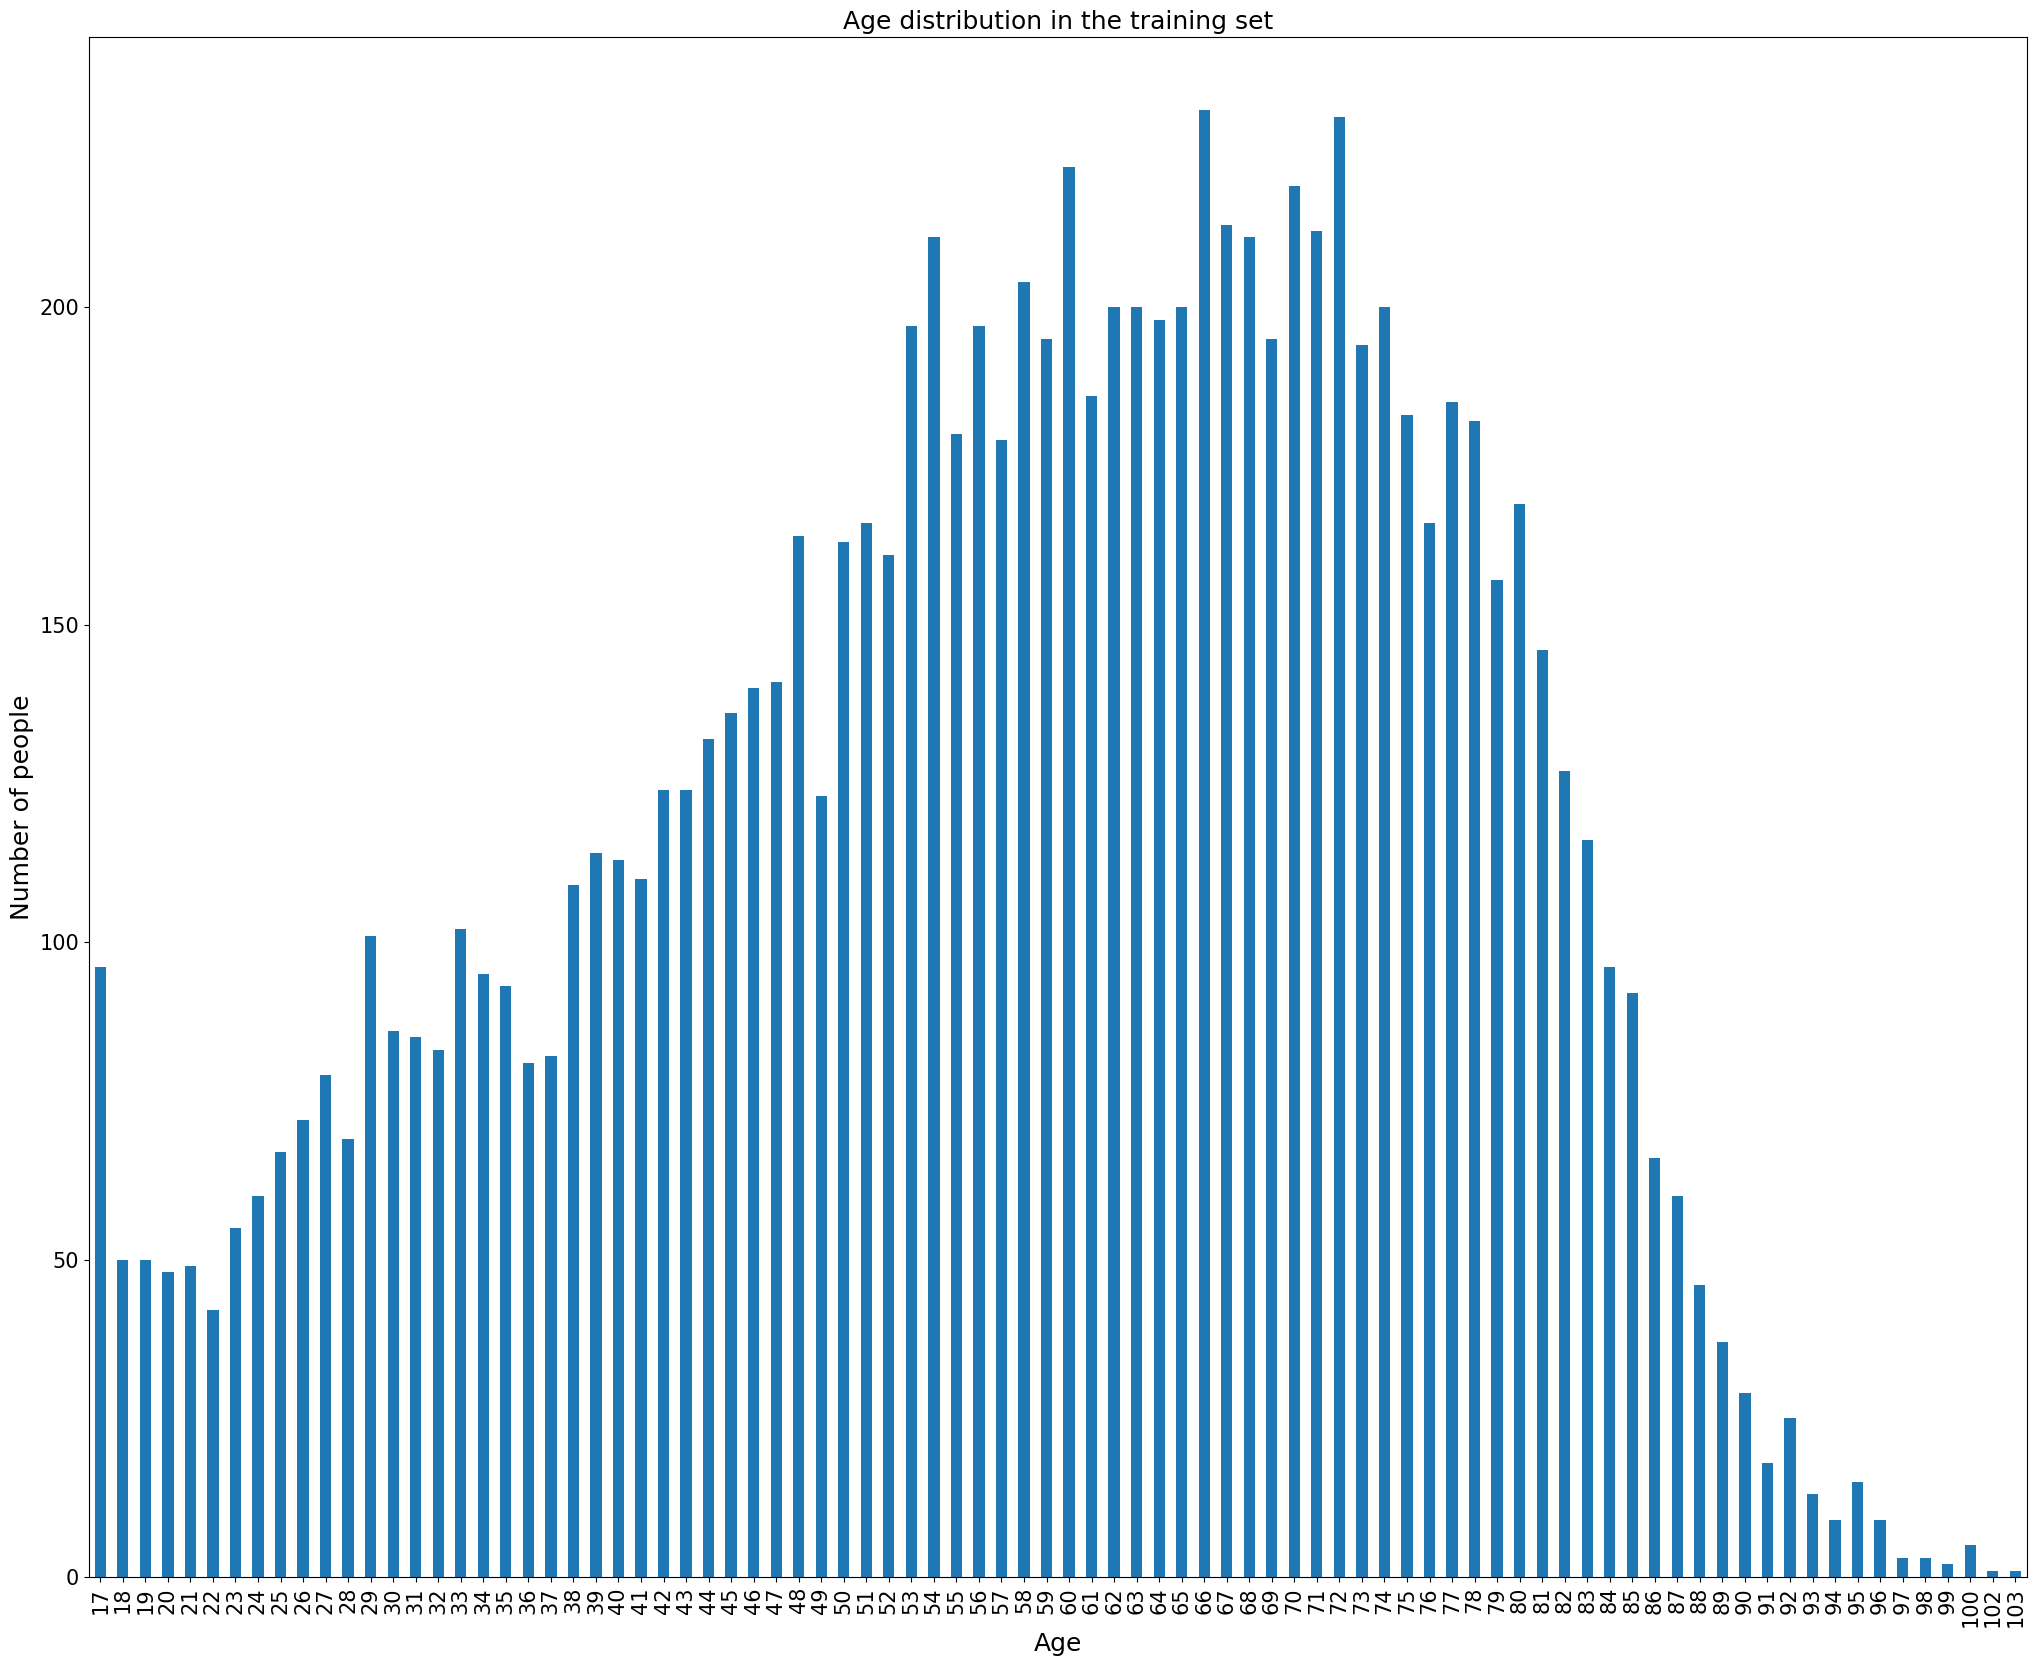

In [ ]:
"""
TASK: Insert your code here (Done)
"""
import h5py
PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']

data_sample = data[0].T # Transpose: Shape should be [8, 4096(Re-sampled length)] which has been verified by testing plot_from_ecg file
plt.figure()
# Value of "columns" can be 1 or 2 which matchs the figure format of first figure (before pre-processing) and second one.
ecg_plot.plot(data_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=2, title='Example ECG from train.h5')
plt.show()

# Additional task 1&2: check the balance of the data set / sex & age:
data_info = pd.read_csv('codesubset/train.csv')

AF_distribution = 'AF'
AF_counts = data_info[AF_distribution].value_counts()
labels_AF = ['AF negative', 'AF postive']
sizes_AF = [AF_counts[0], AF_counts[1]]

sex_distribution = 'sex'
sex_counts = data_info[sex_distribution].value_counts()
labels_sex = ['Female', 'Male']
sizes_sex = [sex_counts['F'], sex_counts['M']]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizes_AF, labels=labels_AF, autopct='%1.1f%%')
ax1.set_title('Distribution of AF')
ax2.pie(sizes_sex, labels=labels_sex, autopct='%1.1f%%')
ax2.set_title('Distribution of sex')
plt.subplots_adjust(wspace=0.4)
plt.show()

age_distribution = 'age'
age_counts = data_info[age_distribution].value_counts()
age_counts = age_counts.sort_index(ascending = True)

plt.figure(figsize = (25,20))
age_counts.plot(kind='bar')
plt.xlabel('Age',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('Age distribution in the training set',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />

**<font color='red'>Your explanation here:</font>** 1, Label is not balanced: the training set contains 3000 AF postive patients and 7000 AF negative patients samples which leads class imbalance issue. 2, Similary, the input feature 'sex' has the same problem (6307 female and 3693 male) which may leads biased model.
<br> Normally, pre-processing is used to clean and normalise the data, and also deal with the imbalanced data, which imporve the model performance and make model effectively learning from all features equally.
Four pre-processing are applied: 1, resampling all ECG traces, which make sure the time intervals are equal among all samples. 2, zero padding can make all samples share the same shape, which is a nomalisation method. 3, removing trends in the ECG signal can reduce the adverse effects to the classification performance from signal trends. 4, removing possible power line noise can reduce the noise which will improve the classification performance.


---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [ ]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128) # == 32

        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))

        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [ ]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.kernel_size_conv1 = 16
        self.kernel_size_conv2 = 9
        self.kernel_size_conv3 = 7
        self.kernel_size_conv4 = 5
        self.kernel_size_conv5 = 3
        #self.kernel_size_conv6 = 3

        channel_in = 8

        conv1_in = 4096
        conv1_out = 1024
        out_channels_conv1 = 128

        conv2_in = conv1_out
        conv2_out = 512
        out_channels_conv2 = 256

        conv3_in = conv2_out
        conv3_out = 256
        out_channels_conv3 = 512

        conv4_in = conv3_out
        conv4_out = 128
        out_channels_conv4 = 1024

        conv5_in = conv4_out
        conv5_out = 64
        out_channels_conv5 = 1024

        """
        conv6_in = conv5_out
        conv6_out = 64
        out_channels_conv6 = 2048
        """

        downsample_conv1 = self._downsample(conv1_in, conv1_out)
        self.conv1 = nn.Conv1d(in_channels = channel_in,
                               out_channels = out_channels_conv1,
                               kernel_size = self.kernel_size_conv1,
                               stride = downsample_conv1,
                               padding = self._padding(self.kernel_size_conv1, downsample_conv1),
                               bias = False)
        self.bn1 = nn.BatchNorm1d(out_channels_conv1)

        downsample_conv2 = self._downsample(conv2_in, conv2_out)
        self.conv2 = nn.Conv1d(in_channels = out_channels_conv1,
                               out_channels = out_channels_conv2,
                               kernel_size = self.kernel_size_conv2,
                               stride = downsample_conv2,
                               padding = self._padding(self.kernel_size_conv2, downsample_conv2),
                               bias = False)
        self.bn2 = nn.BatchNorm1d(out_channels_conv2)

        downsample_conv3 = self._downsample(conv3_in, conv3_out)
        self.conv3 = nn.Conv1d(in_channels = out_channels_conv2,
                               out_channels = out_channels_conv3,
                               kernel_size = self.kernel_size_conv3,
                               stride = downsample_conv3,
                               padding = self._padding(self.kernel_size_conv3, downsample_conv3),
                               bias = False)
        self.bn3 = nn.BatchNorm1d(out_channels_conv3)

        downsample_conv4 = self._downsample(conv4_in, conv4_out)
        self.conv4 = nn.Conv1d(in_channels = out_channels_conv3,
                               out_channels = out_channels_conv4,
                               kernel_size = self.kernel_size_conv4,
                               stride = downsample_conv4,
                               padding = self._padding(self.kernel_size_conv4, downsample_conv4),
                               bias = False)
        self.bn4 = nn.BatchNorm1d(out_channels_conv4)

        downsample_conv5 = self._downsample(conv5_in, conv5_out)
        self.conv5 = nn.Conv1d(in_channels = out_channels_conv4,
                               out_channels = out_channels_conv5,
                               kernel_size = self.kernel_size_conv5,
                               stride = downsample_conv5,
                               padding = self._padding(self.kernel_size_conv5, downsample_conv5),
                               bias = False)
        self.bn5 = nn.BatchNorm1d(out_channels_conv5)

        """
        downsample_conv6 = self._downsample(conv6_in, conv6_out)
        self.conv6 = nn.Conv1d(in_channels = out_channels_conv5,
                               out_channels = out_channels_conv6,
                               kernel_size = self.kernel_size_conv6,
                               stride = downsample_conv6,
                               padding = self._padding(self.kernel_size_conv6, downsample_conv6),
                               bias = False)
        self.bn6 = nn.BatchNorm1d(out_channels_conv6)
        """

        """
        ### Block for hybrid CNN + RNN
        self.rnn = nn.GRU(input_size = out_channels_conv5,
                          hidden_size = out_channels_conv5 // 2,
                          num_layers = 2,
                          dropout = 0.7)
        self.fc1 = nn.Linear(in_features = out_channels_conv5 // 2, out_features = 512)
        ###
        """
        self.fc1 = nn.Linear(in_features = self._calFCin(out_channels_conv5, conv5_out, 5), out_features = 512)

        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(in_features = 512, out_features = 1)

    def _padding(self, k_size, downsample):
        return max(0, int(np.floor((k_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)

    def _calFCin(self, orig_c, orig_o, num_pool):
        fc_in = orig_c * orig_o
        for i in range (0, num_pool):
          fc_in = (fc_in - 2) // 2 + 1
        return fc_in

    def forward(self, x):
        x = x.transpose(2,1)

        x = nn.functional.leaky_relu(self.conv1(x))
        x = self.bn1(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = nn.functional.leaky_relu(self.conv2(x))
        x = self.bn2(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = nn.functional.leaky_relu(self.conv3(x))
        x = self.bn3(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = nn.functional.leaky_relu(self.conv4(x))
        x = self.bn4(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = nn.functional.leaky_relu(self.conv5(x))
        x = self.bn5(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        """
        x = nn.functional.relu(self.conv6(x))
        x = self.bn6(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)
        """

        """
        ## Block for hybrid CNN + RNN
        x = x.permute(0, 2, 1)
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        ##
        """

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.dropout(x)
        x = nn.functional.leaky_relu(x)

        x = self.fc2(x)
        x = self.dropout(x)

        return x

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>** This model contains 5 conv layers with 2 fully connected layers. If the network too shallow, it cannot learn features well. If the network too deep, it shows overfitting problem and computational costs are expensive. We used a large kernel to capture larger spatial patterns at the first conv layer. After that, we use smaller kernel to capture more fine-grained details. We also use batchnorm layer and maxpooling layer to help us to train a deep network. The dropout techniques are used to alleviate overfitting problem. (PLease CHECK this answer when we decide the final model)


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [ ]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code. (Done)
        """
        optimizer.zero_grad()
        model_out = model.forward(traces)
        loss = loss_function(model_out, diagnoses.float())
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [ ]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code. (Done)
        """
        with torch.no_grad():
          model_predications = model.forward(traces)
          loss = loss_function(model_predications, diagnoses.float())
          valid_pred.append(model_predications.detach().cpu().numpy())
          valid_true.append(diagnoses.detach().cpu().numpy())

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>** High learning rate causes the occillision around the minimum point and hence we applied smaller learning rate with the learning rate decay strategy to solve the above problem, however, it will be trapped into local minimum. We choose number of epochs is 100 because too many epochs are not necessary, and model cannot converge within too few epochs. We choose a relatively small batch size because the large batch size leads slower convergence although it increases the training efficiency.


In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary (Done)
"""
learning_rate = 1e-4
weight_decay = 1e-2
num_epochs = 100
batch_size = 32

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here. (Done)
This can be done in <=4 line of code
"""
training_ratio = 0.8
train_size = int(training_ratio * len_dataset)
validation_size = len_dataset - train_size
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [train_size, validation_size])

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

# This is our addtional code to check whether the training dataset has imbalancing label

label_count = 0
for _, label in dataset_train:
    if label == 1:
        label_count += 1

print("Number of label 1 in dataset_train:", label_count)


Use device: cuda

Building data loaders...
Done!

Number of label 1 in dataset_train: 2408


---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain hard predction (0,1) instead of soft predictions (probabilities).

In [ ]:
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here (Done)
"""
model = Model()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code (Done)
"""
loss_function = nn.BCEWithLogitsLoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
# Notice we change Adam to NAdam
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here (Done)
"""
#lr_scheduler = None
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True)


# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf

###########
best_f1 = 0
###########
# allocation
train_loss_all, valid_loss_all = [], []

## This code for additional analysis
auroc = []
avg_pre = []
acc_s = []
f1_s = []
####################################

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)
    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation

    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here (Done)
    This can be done e.g. in 5 lines of code
    """
    y_pred_labels = torch.sigmoid(torch.tensor(y_pred)) > 0.5
    y_pred_labels_np = y_pred_labels.numpy()
    auroc.append(roc_auc_score(y_true, y_pred))
    #auroc.append(roc_auc_score(y_true, y_pred_labels_np))

    # Here are other metircs to satisify the requirement
    avg_pre.append(average_precision_score(y_true, y_pred))
    acc_s.append(accuracy_score(y_true, y_pred_labels_np))
    f1_s.append(f1_score(y_true, y_pred_labels_np))
    print("AUROC: {:.4f}; AP: {:.4f}; ACC: {:.4f}; F1: {:.4f} in epoch {}\n".format(auroc[epoch-1], avg_pre[epoch-1], acc_s[epoch-1], f1_s[epoch-1], epoch))

    """
    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""
    """

    ############ You can change f1_s realted to AUC realted to maximise AUC
    # Note this is our customised saving method which may not allowed
    if (valid_loss < best_loss) and best_f1 < 0.95 and (f1_s[epoch-1] < 0.95):
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        model_save_state = "Best model -> saved"
    elif (f1_s[epoch-1] >= 0.95) and (f1_s[epoch-1] > best_f1):
        torch.save({'model': model.state_dict()}, 'model.pth')
        best_f1 = f1_s[epoch-1]
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""
    ########


    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step(valid_loss)

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here (Done)
"""
plt.plot(train_loss_all, label='Training Loss')
plt.plot(valid_loss_all, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val loss')
plt.legend()
plt.show()

# The addtional code only for us
plt.plot(auroc, label='auroc')
plt.plot(avg_pre, label='average precision')
plt.plot(acc_s, label='accuracy')
plt.plot(f1_s, label='f1 score')

plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Metrics')
plt.legend()
plt.show()

Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/100 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.8439; AP: 0.6587; ACC: 0.7440; F1: 0.3281 in epoch 1

Epoch  1: 	Train Loss 0.020918 	Valid Loss 0.015499 	Best model -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.8998; AP: 0.7543; ACC: 0.7690; F1: 0.4296 in epoch 2

Epoch  2: 	Train Loss 0.018700 	Valid Loss 0.014067 	Best model -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9127; AP: 0.8230; ACC: 0.8440; F1: 0.6810 in epoch 3

Epoch  3: 	Train Loss 0.016960 	Valid Loss 0.011195 	Best model -> saved


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9365; AP: 0.8451; ACC: 0.8135; F1: 0.5737 in epoch 4

Epoch  4: 	Train Loss 0.016104 	Valid Loss 0.011001 	Best model -> saved


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9512; AP: 0.8794; ACC: 0.8095; F1: 0.5480 in epoch 5

Epoch  5: 	Train Loss 0.015616 	Valid Loss 0.011682 	


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9656; AP: 0.9167; ACC: 0.8480; F1: 0.6637 in epoch 6

Epoch  6: 	Train Loss 0.015178 	Valid Loss 0.009948 	Best model -> saved


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9697; AP: 0.9113; ACC: 0.8645; F1: 0.7249 in epoch 7

Epoch  7: 	Train Loss 0.014459 	Valid Loss 0.008116 	Best model -> saved


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9790; AP: 0.9425; ACC: 0.9180; F1: 0.8464 in epoch 8

Epoch  8: 	Train Loss 0.014321 	Valid Loss 0.006539 	Best model -> saved


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9773; AP: 0.9309; ACC: 0.8870; F1: 0.7776 in epoch 9

Epoch  9: 	Train Loss 0.013851 	Valid Loss 0.007292 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9777; AP: 0.9384; ACC: 0.8700; F1: 0.7263 in epoch 10

Epoch 10: 	Train Loss 0.013762 	Valid Loss 0.008374 	


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9800; AP: 0.9428; ACC: 0.9030; F1: 0.8138 in epoch 11

Epoch 11: 	Train Loss 0.013473 	Valid Loss 0.006664 	


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9788; AP: 0.9264; ACC: 0.9135; F1: 0.8411 in epoch 12

Epoch 12: 	Train Loss 0.013334 	Valid Loss 0.006163 	Best model -> saved


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9833; AP: 0.9517; ACC: 0.9030; F1: 0.8124 in epoch 13

Epoch 13: 	Train Loss 0.013279 	Valid Loss 0.006670 	


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9855; AP: 0.9544; ACC: 0.9120; F1: 0.8317 in epoch 14

Epoch 14: 	Train Loss 0.013082 	Valid Loss 0.006181 	


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9845; AP: 0.9588; ACC: 0.9500; F1: 0.9148 in epoch 15

Epoch 15: 	Train Loss 0.013235 	Valid Loss 0.005599 	Best model -> saved


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9862; AP: 0.9605; ACC: 0.9165; F1: 0.8393 in epoch 16

Epoch 16: 	Train Loss 0.012927 	Valid Loss 0.006396 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9865; AP: 0.9632; ACC: 0.9430; F1: 0.8989 in epoch 17

Epoch 17: 	Train Loss 0.013212 	Valid Loss 0.005548 	Best model -> saved


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9844; AP: 0.9667; ACC: 0.9515; F1: 0.9160 in epoch 18

Epoch 18: 	Train Loss 0.012988 	Valid Loss 0.005505 	Best model -> saved


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9798; AP: 0.9660; ACC: 0.9525; F1: 0.9173 in epoch 19

Epoch 19: 	Train Loss 0.012717 	Valid Loss 0.005214 	Best model -> saved


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9761; AP: 0.9560; ACC: 0.9490; F1: 0.9091 in epoch 20

Epoch 20: 	Train Loss 0.013173 	Valid Loss 0.007227 	


Training Epoch 21:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 21:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9852; AP: 0.9657; ACC: 0.9510; F1: 0.9145 in epoch 21

Epoch 21: 	Train Loss 0.012812 	Valid Loss 0.005370 	


Training Epoch 22:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 22:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9890; AP: 0.9727; ACC: 0.9580; F1: 0.9283 in epoch 22

Epoch 22: 	Train Loss 0.012617 	Valid Loss 0.004931 	Best model -> saved


Training Epoch 23:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 23:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9853; AP: 0.9617; ACC: 0.9555; F1: 0.9258 in epoch 23

Epoch 23: 	Train Loss 0.012893 	Valid Loss 0.005312 	


Training Epoch 24:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 24:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9871; AP: 0.9612; ACC: 0.9495; F1: 0.9105 in epoch 24

Epoch 24: 	Train Loss 0.012614 	Valid Loss 0.005324 	


Training Epoch 25:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 25:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9922; AP: 0.9788; ACC: 0.9675; F1: 0.9445 in epoch 25

Epoch 25: 	Train Loss 0.012888 	Valid Loss 0.004275 	Best model -> saved


Training Epoch 26:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 26:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9881; AP: 0.9628; ACC: 0.9635; F1: 0.9371 in epoch 26

Epoch 26: 	Train Loss 0.013007 	Valid Loss 0.005266 	


Training Epoch 27:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 27:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9878; AP: 0.9698; ACC: 0.9605; F1: 0.9317 in epoch 27

Epoch 27: 	Train Loss 0.012719 	Valid Loss 0.006235 	


Training Epoch 28:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 28:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9880; AP: 0.9599; ACC: 0.9435; F1: 0.8970 in epoch 28

Epoch 28: 	Train Loss 0.012694 	Valid Loss 0.005625 	


Training Epoch 29:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 29:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9897; AP: 0.9748; ACC: 0.9635; F1: 0.9384 in epoch 29

Epoch 29: 	Train Loss 0.012723 	Valid Loss 0.005406 	


Training Epoch 30:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 30:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9855; AP: 0.9537; ACC: 0.9520; F1: 0.9182 in epoch 30

Epoch 30: 	Train Loss 0.012593 	Valid Loss 0.004913 	


Training Epoch 31:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 31:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9904; AP: 0.9762; ACC: 0.9705; F1: 0.9495 in epoch 31

Epoch 31: 	Train Loss 0.012735 	Valid Loss 0.004891 	
Epoch 00031: reducing learning rate of group 0 to 8.0000e-05.


Training Epoch 32:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 32:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9894; AP: 0.9751; ACC: 0.9600; F1: 0.9313 in epoch 32

Epoch 32: 	Train Loss 0.012652 	Valid Loss 0.005010 	


Training Epoch 33:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 33:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9900; AP: 0.9780; ACC: 0.9630; F1: 0.9385 in epoch 33

Epoch 33: 	Train Loss 0.012634 	Valid Loss 0.005069 	


Training Epoch 34:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 34:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9884; AP: 0.9709; ACC: 0.9635; F1: 0.9377 in epoch 34

Epoch 34: 	Train Loss 0.012433 	Valid Loss 0.005225 	


Training Epoch 35:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 35:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9902; AP: 0.9748; ACC: 0.9650; F1: 0.9415 in epoch 35

Epoch 35: 	Train Loss 0.012383 	Valid Loss 0.005329 	


Training Epoch 36:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 36:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9901; AP: 0.9767; ACC: 0.9635; F1: 0.9393 in epoch 36

Epoch 36: 	Train Loss 0.012490 	Valid Loss 0.005545 	


Training Epoch 37:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 37:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9911; AP: 0.9773; ACC: 0.9685; F1: 0.9467 in epoch 37

Epoch 37: 	Train Loss 0.012694 	Valid Loss 0.005509 	
Epoch 00037: reducing learning rate of group 0 to 6.4000e-05.


Training Epoch 38:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 38:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9895; AP: 0.9692; ACC: 0.9590; F1: 0.9304 in epoch 38

Epoch 38: 	Train Loss 0.012441 	Valid Loss 0.005103 	


Training Epoch 39:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 39:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9920; AP: 0.9806; ACC: 0.9680; F1: 0.9441 in epoch 39

Epoch 39: 	Train Loss 0.012574 	Valid Loss 0.005012 	


Training Epoch 40:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 40:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9899; AP: 0.9774; ACC: 0.9690; F1: 0.9474 in epoch 40

Epoch 40: 	Train Loss 0.012509 	Valid Loss 0.005310 	


Training Epoch 41:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 41:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9899; AP: 0.9783; ACC: 0.9710; F1: 0.9508 in epoch 41

Epoch 41: 	Train Loss 0.012418 	Valid Loss 0.004794 	Best model -> saved


Training Epoch 42:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 42:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9922; AP: 0.9791; ACC: 0.9730; F1: 0.9538 in epoch 42

Epoch 42: 	Train Loss 0.012395 	Valid Loss 0.005152 	Best model -> saved


Training Epoch 43:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 43:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9868; AP: 0.9586; ACC: 0.9515; F1: 0.9199 in epoch 43

Epoch 43: 	Train Loss 0.012474 	Valid Loss 0.005759 	
Epoch 00043: reducing learning rate of group 0 to 5.1200e-05.


Training Epoch 44:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 44:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9896; AP: 0.9733; ACC: 0.9730; F1: 0.9539 in epoch 44

Epoch 44: 	Train Loss 0.012321 	Valid Loss 0.005163 	Best model -> saved


Training Epoch 45:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 45:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9912; AP: 0.9792; ACC: 0.9680; F1: 0.9462 in epoch 45

Epoch 45: 	Train Loss 0.012183 	Valid Loss 0.004787 	


Training Epoch 46:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 46:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9886; AP: 0.9653; ACC: 0.9625; F1: 0.9360 in epoch 46

Epoch 46: 	Train Loss 0.012139 	Valid Loss 0.004969 	


Training Epoch 47:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 47:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9901; AP: 0.9761; ACC: 0.9725; F1: 0.9534 in epoch 47

Epoch 47: 	Train Loss 0.012138 	Valid Loss 0.005190 	


Training Epoch 48:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 48:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9889; AP: 0.9808; ACC: 0.9710; F1: 0.9505 in epoch 48

Epoch 48: 	Train Loss 0.011993 	Valid Loss 0.004806 	


Training Epoch 49:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 49:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9926; AP: 0.9838; ACC: 0.9685; F1: 0.9472 in epoch 49

Epoch 49: 	Train Loss 0.012013 	Valid Loss 0.004886 	
Epoch 00049: reducing learning rate of group 0 to 4.0960e-05.


Training Epoch 50:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 50:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9927; AP: 0.9823; ACC: 0.9755; F1: 0.9585 in epoch 50

Epoch 50: 	Train Loss 0.012143 	Valid Loss 0.004552 	Best model -> saved


Training Epoch 51:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 51:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9924; AP: 0.9816; ACC: 0.9685; F1: 0.9472 in epoch 51

Epoch 51: 	Train Loss 0.011968 	Valid Loss 0.004727 	


Training Epoch 52:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 52:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9920; AP: 0.9812; ACC: 0.9635; F1: 0.9390 in epoch 52

Epoch 52: 	Train Loss 0.012058 	Valid Loss 0.005648 	


Training Epoch 53:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 53:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9915; AP: 0.9805; ACC: 0.9725; F1: 0.9537 in epoch 53

Epoch 53: 	Train Loss 0.011874 	Valid Loss 0.004949 	


Training Epoch 54:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 54:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9920; AP: 0.9803; ACC: 0.9680; F1: 0.9462 in epoch 54

Epoch 54: 	Train Loss 0.011945 	Valid Loss 0.005260 	


Training Epoch 55:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 55:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9904; AP: 0.9726; ACC: 0.9695; F1: 0.9489 in epoch 55

Epoch 55: 	Train Loss 0.012118 	Valid Loss 0.005485 	
Epoch 00055: reducing learning rate of group 0 to 3.2768e-05.


Training Epoch 56:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 56:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9914; AP: 0.9810; ACC: 0.9735; F1: 0.9547 in epoch 56

Epoch 56: 	Train Loss 0.011943 	Valid Loss 0.005178 	


Training Epoch 57:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 57:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9930; AP: 0.9853; ACC: 0.9720; F1: 0.9526 in epoch 57

Epoch 57: 	Train Loss 0.011971 	Valid Loss 0.004663 	


Training Epoch 58:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 58:   0%|          | 0/63 [00:00<?, ?it/s]

AUROC: 0.9900; AP: 0.9802; ACC: 0.9700; F1: 0.9484 in epoch 58

Epoch 58: 	Train Loss 0.012076 	Valid Loss 0.004968 	


Training Epoch 59:   0%|          | 0/250 [00:00<?, ?it/s]

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [ ]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [ ]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here (Done)
"""
model = Model()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [ ]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), 631 bytes | 631.00 KiB/s, done.


In [ ]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password. (Done)
Do not change this after you have registered your team
"""
team_id = 'Y' #Fill in a string
password = 'B2023Feb' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [ ]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'Stable' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>** The first submission called 'TemporaryVer' and the second submission called 'Stable'. The main changes of these two version are optimiser (Adam to NAdam) with higher dropout rate to provide stronger regularisation capability. We submit the thrid version 'MPtoAP'and try to figure out the effects of the output shape of the kernel by revising the output size of the kernel. However, it seems no improvment on generalisation in test set although it shows 0.967 F1 score on val set.

Your team id: **<font color='red'>Y</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|TemporaryVer     | 0.951| 0.949| 0.987| 0.985| First version with little oscillation  |
|Stable              | 0.951        | 0.950  | 0.983   | 0.976  | Stable loss curve                   |
|MPtoAP              | 0.950        | 0.949  | 0.982   | 0.972  | Change the output size of kernel                  |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**